In [1]:
# Import the required libraries 
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

The standard form formula of quadratic programming is ===>
    min(1/2)x(T) * (p)(x) + q(T) * x     Subject to   Gx <= h , Ax= b

We need to convert SVM to QP form.
The standard form formola of  the dual problem using qp is===>
    
    min (1/2)a(T) * H(a) - a             Subject to  −a(i)≤0 , y(T)a=0

In [3]:
class SVM(object):

    def __init__(self, kernel=linear_kernel):
        self.kernel = kernel
        

    def fit(self, X, y):
        n_samples, n_features = X.shape
        print("input shape is : " , X.shape) # A matrix with shape 200 * 2

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j]) # Matrix K is 200 * 200
  

        P = cvxopt.matrix(np.outer(y,y) * K) # P is a positive-definite matrix ( matrix in qp func to be minimizes)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
        q = cvxopt.matrix(np.ones(n_samples) * -1) # The vector q has all entries −1( vectors in qp func to be minimizes)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0) # vectors holding values of b defult =0

        
        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # find Lagrange multipliers
        landa = np.ravel(solution['x'])
        #print("landas for all sampels :",landa)
        
        # find index that have non zero lagrange multipliers ( support vectors )
        sv = landa > 1e-5

        index = np.arange(len(landa))[sv] #index for landas that have non zero lagrange multipliers
        #print("Index of support vectors: ",index)

        self.landa = landa[sv] 
        self.sv = X[sv] 
        self.sv_y = y[sv] 
        print("Landas are :" , self.landa) # print landas
        print("support vector coordinates are : " , self.sv)  #point coordinates that have non zero lagrange multipliers
        print("support vector labels are :" , self.sv_y) #labels for support vectors


        # Weight vector
        
        self.w = np.zeros(n_features)
        for n in range(len(self.landa)):
            self.w += self.landa[n] * self.sv_y[n] * self.sv[n]  # landa(t) * x(t) * y(t)
        print("weights are: " , self.w)   
        
        # bais
        self.b = 0
        for n in range(len(self.landa)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.landa * self.sv_y * K[index[n],sv]) # landa(t) * y(t)
        self.b /= len(self.landa)
        print("bais is: " , self.b)  

input shape is :  (200, 2)
     pcost       dcost       gap    pres   dres
 0: -1.6174e+01 -3.1253e+01  6e+02  2e+01  2e+00
 1: -1.7723e+01 -1.3629e+01  2e+02  8e+00  6e-01
 2: -2.4004e+01 -1.0634e+01  1e+02  4e+00  3e-01
 3: -5.1129e+00 -5.3136e+00  3e+01  7e-01  6e-02
 4: -3.3204e+00 -4.4061e+00  1e+00  2e-15  2e-15
 5: -4.2550e+00 -4.2968e+00  4e-02  3e-15  2e-15
 6: -4.2887e+00 -4.2891e+00  4e-04  2e-15  2e-15
 7: -4.2891e+00 -4.2891e+00  4e-06  5e-15  2e-15
Optimal solution found.
Landas are : [3.72526065 0.56380882 4.28906946]
support vector coordinates are :  [[-0.46305158 -0.10260379]
 [ 2.05804034  2.93684917]
 [ 0.39394274 -0.13901427]]
support vector labels are : [ 1.  1. -1.]
weights are:  [-2.25429434  1.86983743]
bais is:  0.1479976701512465


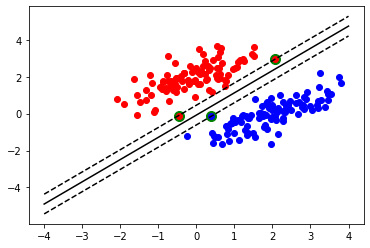

In [6]:
if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate train data
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2


    def join_X_y(X1, y1, X2, y2):
        sampels = np.vstack((X1, X2))
        labels = np.hstack((y1, y2)) 
        return sampels, labels 
       

    def plot_margin(X1_plt, X2_plt, clf):
        def line_mrg(x, w, b, c=0):
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]
            
        # plot decision boundray and margin
        pl.plot(X1_plt[:,0], X1_plt[:,1], "ro")
        pl.plot(X2_plt[:,0], X2_plt[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = line_mrg(a0, clf.w, clf.b)
        b0 = 4; b1 = line_mrg(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = line_mrg(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = line_mrg(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = line_mrg(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = line_mrg(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        sampels, labels = join_X_y(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(sampels, labels)

        plot_margin(sampels[labels==1], sampels[labels==-1], clf)



    test_linear()